In [1]:
# Import relevant libraries
import gym
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from gym.envs.toy_text.frozen_lake import generate_random_map, FrozenLakeEnv
from matplotlib import colors
import hiive.mdptoolbox as mdptoolbox
from hiive.mdptoolbox.mdp import ValueIteration, PolicyIteration, QLearning, PolicyIterationModified
import random
from timeit import default_timer as timer
from datetime import timedelta
import time
import copy
# Set the random seed
np.random.seed(42)

In [2]:
# Set up helper functions
colors = {
    b'S': 'b',
    b'F': 'w',
    b'H': 'r',
    b'G': 'g'
}

directions = {
            0: '←',
            1: '↓',
            2: '→',
            3: '↑'
}

def plot_lake(env, policy=None, title ='Frozen Lake 4x4'):
    squares = env.nrow
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, xlim=(-.01, squares+0.01), ylim=(-.01, squares+0.01))
    plt.title(title, fontsize=16, weight='bold', y=1.01)
    for i in range(squares):
        for j in range(squares):
            y = squares - i - 1
            x = j
            p = plt.Rectangle([x, y], 1, 1, linewidth=1, edgecolor='k')
            p.set_facecolor(colors[env.desc[i,j]])
            ax.add_patch(p)
            
            if policy is not None:
                text = ax.text(x+0.5, y+0.5, directions[policy[i, j]],
                               horizontalalignment='center', size=25, verticalalignment='center',
                               color='k')
            
    plt.axis('off')
    plt.show()
    
def plot_lake_values(env, policy=None, title ='Frozen Lake 4x4'):
    squares = env.nrow
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, xlim=(-.01, squares+0.01), ylim=(-.01, squares+0.01))
    plt.title(title, fontsize=16, weight='bold', y=1.01)
    for i in range(squares):
        for j in range(squares):
            y = squares - i - 1
            x = j
            p = plt.Rectangle([x, y], 1, 1, linewidth=1, edgecolor='k')
            p.set_facecolor(colors[env.desc[i,j]])
            ax.add_patch(p)
            
            if policy is not None:
                text = ax.text(x+0.5, y+0.5, "{:.4f}".format(policy[i, j]),
                               horizontalalignment='center', size=15, verticalalignment='center',
                               color='k')
            
    plt.axis('off')
    plt.show()
    
def get_score(env, policy, printInfo=False, episodes=100):
    misses = 0
    steps_list = []
    for episode in range(episodes):
        observation = env.reset()
        steps=0
        while True:
            action = policy[observation]
            observation, reward, done, _ = env.step(action)
            steps+=1
            if done and reward == 1:
                steps_list.append(steps)
                break
            elif done and reward == 0:
                misses += 1
                break
    ave_steps = np.mean(steps_list)
    std_steps = np.std(steps_list)
    pct_fail  = (misses/episodes)* 100
    
    return ave_steps, std_steps, pct_fail

def get_score_mod(env, policy, printInfo=False, episodes=100):
    misses = 0
    steps_list = []
    for episode in range(episodes):
        observation = env.reset()
        steps=0
        while True:
            action = policy[observation]
            observation, reward, done, _ = env.step(action)
            steps+=1
            if done and reward == 1:
                steps_list.append(steps)
                break
            elif done and reward == 0:
                misses += 1
                break
    ave_steps = np.mean(steps_list)
    std_steps = np.std(steps_list)
    pct_fail  = (misses/episodes)* 100
    pct_pass  = 100-pct_fail
    
    return pd.Series([ave_steps, std_steps, pct_pass])

In [5]:
# Define a custom map for 16x16 grid world
MAPS = {
    "4x4": [
    "SFFF",
    "FHFH",
    "FFFH",
    "HFFG"
    ],
    
    "16x16": [
    "SFFFFFFHFFFHHFFF",
    "FFFFFFFFFFFFFFFF",
    "FHHHFFFFFFFHFFFF",
    "FFHFHHFHFFFFFFHF",
    "FFFHFHFFFHFFFFFF",
    "HFFFFFFFHFFFFFFF",
    "FFFFFFFFHFFFFFFF",
    "HHFHHFHFHHFFFFHH",
    "FFFFFFHFFFFHHFFF",
    "FFFFFFHFFFHFFFFF",
    "FFFFFHFFFFFFFFFF",
    "FFHFFFHHFFHFFFFH",
    "HFFFFHHFFFFHFFFF",
    "FFFFFFFFFFFHFFFF",
    "FFHFHFFFFFFFFFFF",
    "HHHFFHFHHHFFHFFG",
    ]
}

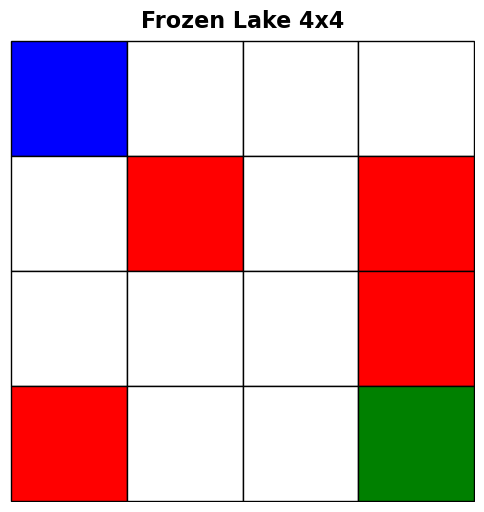

In [6]:
env = gym.make('FrozenLake-v1', desc=MAPS["4x4"], is_slippery=True).unwrapped
# Need to change the values based on number of rows and columns

rows = env.nrow
cols = env.ncol
T = np.zeros((4, rows*cols, rows*cols))
R = np.zeros((4, rows*cols, rows*cols))

old_state = np.inf

for square in env.P:
    for action in env.P[square]:
        for i in range(len(env.P[square][action])):
            new_state = env.P[square][action][i][1]
            if new_state == old_state:
                T[action][square][env.P[square][action][i][1]] = T[action][square][old_state] + env.P[square][action][i][0]
                R[action][square][env.P[square][action][i][1]] = R[action][square][old_state] + env.P[square][action][i][2]
            else:
                T[action][square][env.P[square][action][i][1]] = env.P[square][action][i][0]
                R[action][square][env.P[square][action][i][1]] = env.P[square][action][i][2]
            old_state = env.P[square][action][i][1]
            

plot_lake(env, policy=None, title = 'Frozen Lake 4x4')

In [72]:
def trainQ(P, R, discount=0.9, alpha =[0.01], alpha_dec=[0.99], alpha_min=[0.001], 
            epsilon=[1.0], epsilon_decay=[0.99], n_iter=[1000000]):
    
    q_df = pd.DataFrame(columns=["Iterations",'Gamma','Alpha', "Alpha Decay", "Alpha Min", 
                                 "Epsilon", "Epsilon Decay", "Reward",
                                 "Time", "Policy", "Value Function",
                                 "Training Rewards",
                                 #'Avg_Steps','Steps_StDev','Success_Rate'
                                ])
    q_run_full = pd.DataFrame()
    count = 0
    for i in n_iter:
        for eps in epsilon:
            for eps_dec in epsilon_decay:
                for a_dec in alpha_dec:
                    for a_min in alpha_min:
                        for gamma in discount:
                            for alphas in alpha:
                                q = QLearning(P, R, gamma=gamma,alpha =alphas, alpha_decay=a_dec, 
                                              alpha_min=a_min, epsilon=eps, 
                                              epsilon_decay=eps_dec, n_iter=i)
                                q_run, q_policy = q.run()

                                q_run_df = pd.DataFrame(q_run)
                                q_run_df['Iteration_Run'] = i
                                q_run_df['Gamma_Var'] = gamma
                                q_run_df['Alpha_Var'] = alphas
                                q_run_df['Eps_Var'] = eps
                                reward = max(q_run_df['Reward'])
                                #steps, steps_stddev, failures = get_score(env, q.policy, None)

                                count += 1
                                print("{}: {}".format(count, reward))
                                st = q.run_stats
                                rews = [s['Reward'] for s in st]
                                info = [i,gamma,alphas, a_dec, a_min, eps, eps_dec, reward, 
                                        q.time, q.policy, q.V, rews,
                                        #steps,steps_stddev,
                                        # Success is 100% - failure%
                                        #100-failures
                                       ]

                                df_length = len(q_df)
                                q_df.loc[df_length] = info

                                q_run_full = pd.concat([q_run_full,q_run_df])
                        
    return q_df,q_policy,q_run,q_run_full

In [77]:
%%time
gamma = [0.5,0.9,0.99]
alphas= [0.1,0.01,0.001]
eps = [0.5,1]
iters = [1e6,1e7]
q_df_2,q_policy_2,q_run_2,q_run_full_2 = trainQ(T, R, discount=gamma,alpha=alphas,epsilon=eps,
            n_iter=iters)

1: 1.0
2: 1.0
3: 1.0
4: 1.0
5: 1.0
6: 1.0
7: 1.0
8: 1.0
9: 1.0
10: 1.0
11: 1.0
12: 1.0
13: 1.0
14: 1.0
15: 1.0
16: 1.0
17: 1.0
18: 1.0
19: 1.0
20: 1.0
21: 1.0
22: 1.0
23: 1.0
24: 1.0
25: 1.0
26: 1.0
27: 1.0
28: 1.0
29: 1.0
30: 1.0
31: 1.0
32: 1.0
33: 1.0
34: 1.0
35: 1.0
36: 1.0
Wall time: 1h 22min 17s


In [78]:
q_run_full_1

,State,Action,Reward,Error,Time,Alpha,Epsilon,Gamma,Max V,Mean V,Iteration,Iteration_Run,Gamma_Var,Alpha_Var,Eps_Var
0,2,0,-0.01,0.000370,0.004291,0.036973,0.184865,0.50,0.000000,0.000000,100,1000000.0,0.50,0.100,0.5
1,10,3,-0.01,0.000135,0.007388,0.013533,0.100000,0.50,0.000000,0.000000,200,1000000.0,0.50,0.100,0.5
2,15,3,0.00,0.000000,0.009490,0.004954,0.100000,0.50,0.000000,0.000000,300,1000000.0,0.50,0.100,0.5
3,0,0,-0.01,0.000018,0.011591,0.001813,0.100000,0.50,0.000000,0.000000,400,1000000.0,0.50,0.100,0.5
4,6,1,-0.10,0.000100,0.014715,0.001000,0.100000,0.50,0.000000,0.000000,500,1000000.0,0.50,0.100,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2,0,-0.01,0.000010,274.338322,0.001000,0.100000,0.99,0.527589,0.092632,9996000,10000000.0,0.99,0.001,1.0
9996,0,2,-0.01,0.000035,274.365248,0.001000,0.100000,0.99,0.529190,0.092730,9997000,10000000.0,0.99,0.001,1.0
9997,15,0,0.00,0.000000,274.390224,0.001000,0.100000,0.99,0.528345,0.092731,9998000,10000000.0,0.99,0.001,1.0
9998,2,0,-0.01,0.000030,274.418641,0.001000,0.100000,0.99,0.527483,0.092654,9999000,10000000.0,0.99,0.001,1.0


In [137]:
q1 = q_run_full_1[(q_run_full_1['Alpha_Var']==0.1) & (q_run_full_1['Eps_Var']==0.5)& (q_run_full_1['Gamma_Var']==0.99) & (q_run_full_1['Iteration_Run']==1000000)]

q2 = q_run_full_1[(q_run_full_1['Alpha_Var']==0.1) & (q_run_full_1['Eps_Var']==0.5)& (q_run_full_1['Gamma_Var']==0.5) & (q_run_full_1['Iteration_Run']==10000000)]
q3 = q_run_full_1[(q_run_full_1['Alpha_Var']==0.1) & (q_run_full_1['Eps_Var']==0.5)& (q_run_full_1['Gamma_Var']==0.9) & (q_run_full_1['Iteration_Run']==10000000)]
q4 = q_run_full_1[(q_run_full_1['Alpha_Var']==0.1) & (q_run_full_1['Eps_Var']==0.5)& (q_run_full_1['Gamma_Var']==0.99) & (q_run_full_1['Iteration_Run']==10000000)]
q5 = q_run_full_1[(q_run_full_1['Alpha_Var']==0.01) & (q_run_full_1['Eps_Var']==0.5)& (q_run_full_1['Gamma_Var']==0.5) & (q_run_full_1['Iteration_Run']==10000000)]
q6 = q_run_full_1[(q_run_full_1['Alpha_Var']==0.01) & (q_run_full_1['Eps_Var']==0.5)& (q_run_full_1['Gamma_Var']==0.9) & (q_run_full_1['Iteration_Run']==10000000)]
q7 = q_run_full_1[(q_run_full_1['Alpha_Var']==0.01) & (q_run_full_1['Eps_Var']==0.5)& (q_run_full_1['Gamma_Var']==0.99) & (q_run_full_1['Iteration_Run']==10000000)]

q8 = q_run_full_1[(q_run_full_1['Alpha_Var']==0.01) & (q_run_full_1['Eps_Var']==1)& (q_run_full_1['Gamma_Var']==0.5) & (q_run_full_1['Iteration_Run']==10000000)]
q9 = q_run_full_1[(q_run_full_1['Alpha_Var']==0.01) & (q_run_full_1['Eps_Var']==1)& (q_run_full_1['Gamma_Var']==0.9) & (q_run_full_1['Iteration_Run']==10000000)]
q10 = q_run_full_1[(q_run_full_1['Alpha_Var']==0.01) & (q_run_full_1['Eps_Var']==1)& (q_run_full_1['Gamma_Var']==0.99) & (q_run_full_1['Iteration_Run']==10000000)]


w2 = q_run_full_1[(q_run_full_1['Alpha_Var']==0.1) & (q_run_full_1['Eps_Var']==0.5)& (q_run_full_1['Gamma_Var']==0.5) & (q_run_full_1['Iteration_Run']==1000000)]
w3 = q_run_full_1[(q_run_full_1['Alpha_Var']==0.1) & (q_run_full_1['Eps_Var']==0.5)& (q_run_full_1['Gamma_Var']==0.9) & (q_run_full_1['Iteration_Run']==1000000)]
w4 = q_run_full_1[(q_run_full_1['Alpha_Var']==0.1) & (q_run_full_1['Eps_Var']==0.5)& (q_run_full_1['Gamma_Var']==0.99) & (q_run_full_1['Iteration_Run']==1000000)]
w5 = q_run_full_1[(q_run_full_1['Alpha_Var']==0.01) & (q_run_full_1['Eps_Var']==0.5)& (q_run_full_1['Gamma_Var']==0.5) & (q_run_full_1['Iteration_Run']==1000000)]
w6 = q_run_full_1[(q_run_full_1['Alpha_Var']==0.01) & (q_run_full_1['Eps_Var']==0.5)& (q_run_full_1['Gamma_Var']==0.9) & (q_run_full_1['Iteration_Run']==1000000)]
w7 = q_run_full_1[(q_run_full_1['Alpha_Var']==0.01) & (q_run_full_1['Eps_Var']==0.5)& (q_run_full_1['Gamma_Var']==0.99) & (q_run_full_1['Iteration_Run']==1000000)]

w8 = q_run_full_1[(q_run_full_1['Alpha_Var']==0.01) & (q_run_full_1['Eps_Var']==1)& (q_run_full_1['Gamma_Var']==0.5) & (q_run_full_1['Iteration_Run']==1000000)]
w9 = q_run_full_1[(q_run_full_1['Alpha_Var']==0.01) & (q_run_full_1['Eps_Var']==1)& (q_run_full_1['Gamma_Var']==0.9) & (q_run_full_1['Iteration_Run']==1000000)]
w10 = q_run_full_1[(q_run_full_1['Alpha_Var']==0.01) & (q_run_full_1['Eps_Var']==1)& (q_run_full_1['Gamma_Var']==0.99) & (q_run_full_1['Iteration_Run']==1000000)]


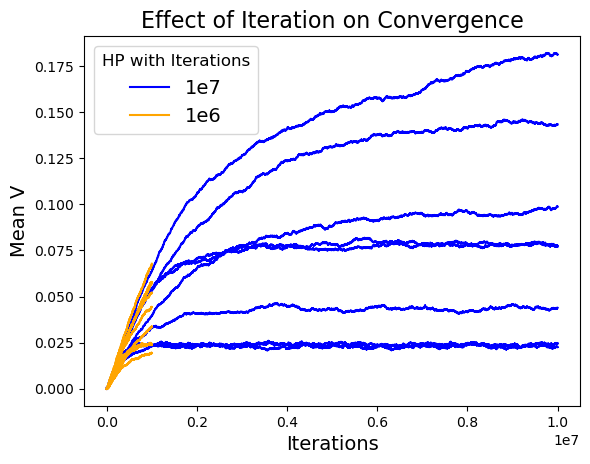

In [138]:
plt.plot(q2['Iteration'], q2['Mean V'], color='b', label='1e7')
plt.plot(q3['Iteration'], q3['Mean V'], color='b')
plt.plot(q4['Iteration'], q4['Mean V'], color='b')
plt.plot(q5['Iteration'], q5['Mean V'], color='b')
plt.plot(q6['Iteration'], q6['Mean V'], color='b')
plt.plot(q7['Iteration'], q7['Mean V'], color='b')
plt.plot(q8['Iteration'], q8['Mean V'], color='b')
plt.plot(q9['Iteration'], q9['Mean V'], color='b')
plt.plot(q10['Iteration'], q10['Mean V'], color='b')

plt.plot(w2['Iteration'], w2['Mean V'], color='orange', label='1e6')
plt.plot(w3['Iteration'], w3['Mean V'], color='orange')
plt.plot(w4['Iteration'], w4['Mean V'], color='orange')
plt.plot(w5['Iteration'], w5['Mean V'], color='orange')
plt.plot(w6['Iteration'], w6['Mean V'], color='orange')
plt.plot(w7['Iteration'], w7['Mean V'], color='orange')
plt.plot(w8['Iteration'], w8['Mean V'], color='orange')
plt.plot(w9['Iteration'], w9['Mean V'], color='orange')
plt.plot(w10['Iteration'], w10['Mean V'], color='orange')

plt.title('Effect of Iteration on Convergence', fontsize=16)
plt.xlabel('Iterations', fontsize=14)
plt.ylabel('Mean V', fontsize=14)
plt.legend(title="HP with Iterations",title_fontsize=12, loc="best",prop={'size': 14})

In [145]:
%%time
applied_df_full_1 =pd.DataFrame()
applied_df_1 = pd.DataFrame(columns=['Avg_Steps', 'StDev_Steps','Success_Rate'])
for i in range(0,5):
    print(i)
    applied_df_1[['Avg_Steps', 'StDev_Steps','Success_Rate']] = q_df_2.apply(lambda x: get_score_mod(env, x["Policy"], None), axis =1)
    applied_df_1 = applied_df_1[['Success_Rate']]
    applied_df_1 = applied_df_1.rename(columns ={'Success_Rate':'Success_Rate_'+str(i)})
    applied_df_1['Gamma'] = q_df_1['Gamma']
    applied_df_1['Alpha'] = q_df_1['Alpha']
    applied_df_1['Epsilon'] = q_df_1['Epsilon']
    applied_df_1['Iterations'] = q_df_1['Iterations']
    
    applied_df_full_1 = pd.concat([applied_df_full_1,applied_df_1], axis =1)

0


C:\Users\UGGTech\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\UGGTech\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\UGGTech\anaconda3\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\UGGTech\anaconda3\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\UGGTech\anaconda3\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1


C:\Users\UGGTech\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\UGGTech\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\UGGTech\anaconda3\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\UGGTech\anaconda3\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\UGGTech\anaconda3\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


2


C:\Users\UGGTech\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\UGGTech\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\UGGTech\anaconda3\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\UGGTech\anaconda3\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\UGGTech\anaconda3\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


3


C:\Users\UGGTech\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\UGGTech\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\UGGTech\anaconda3\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\UGGTech\anaconda3\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\UGGTech\anaconda3\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


4


C:\Users\UGGTech\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\UGGTech\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\UGGTech\anaconda3\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\UGGTech\anaconda3\lib\site-packages\numpy\core\_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Users\UGGTech\anaconda3\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Wall time: 1min 1s


Text(0, 0.5, 'Occurances')

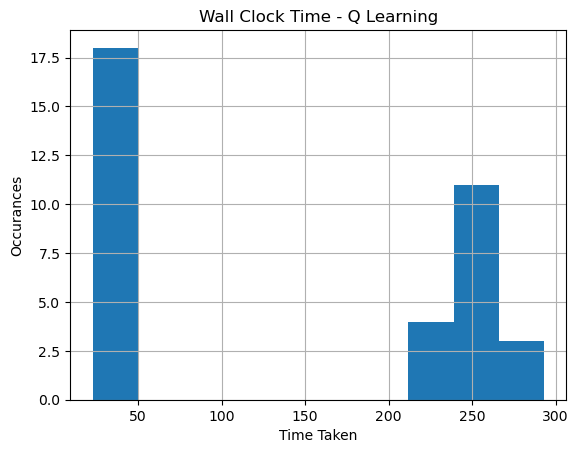

In [170]:
q_df_1['Time'].hist()
plt.title('Wall Clock Time - Q Learning')
plt.xlabel('Time Taken')
plt.ylabel('Occurances')

In [146]:
applied_df_full_1 = applied_df_full_1.loc[:,~applied_df_full_1.columns.duplicated()].copy()


applied_df_full_1['Success_Mean'] = applied_df_full_1.loc[:, ["Success_Rate_0","Success_Rate_1","Success_Rate_2","Success_Rate_3","Success_Rate_4"]].mean(axis = 1)
applied_df_full_1['Success_StdDev'] = applied_df_full_1.loc[:, ["Success_Rate_0","Success_Rate_1","Success_Rate_2","Success_Rate_3","Success_Rate_4"]].std(axis = 1)
applied_df_full_1['Success_Max'] = applied_df_full_1.loc[:, ["Success_Rate_0","Success_Rate_1","Success_Rate_2","Success_Rate_3","Success_Rate_4"]].max(axis = 1)
applied_df_full_1

,Success_Rate_0,Gamma,Alpha,Epsilon,Iterations,Success_Rate_1,Success_Rate_2,Success_Rate_3,Success_Rate_4,Success_Mean,Success_StdDev,Success_Max
0,68.8,0.50,0.100,0.5,1000000.0,71.7,67.8,68.5,71.4,69.64,1.784096,71.7
1,51.7,0.50,0.010,0.5,1000000.0,51.9,54.4,50.4,54.6,52.60,1.828934,54.6
2,51.5,0.50,0.001,0.5,1000000.0,49.3,54.4,52.0,52.2,51.88,1.821263,54.4
3,51.3,0.90,0.100,0.5,1000000.0,50.4,55.2,51.8,52.7,52.28,1.832212,55.2
4,64.8,0.90,0.010,0.5,1000000.0,63.1,64.0,66.8,62.0,64.14,1.816040,66.8
5,50.9,0.90,0.001,0.5,1000000.0,51.9,52.4,54.0,52.0,52.24,1.128273,54.0
7,68.3,0.99,0.010,0.5,1000000.0,68.0,67.2,67.8,66.0,67.46,0.909945,68.3
8,0.0,0.99,0.001,0.5,1000000.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0
9,27.3,0.50,0.100,1.0,1000000.0,26.9,24.3,24.6,26.7,25.96,1.399286,27.3
10,46.5,0.50,0.010,1.0,1000000.0,44.3,45.0,44.3,44.1,44.84,0.988939,46.5


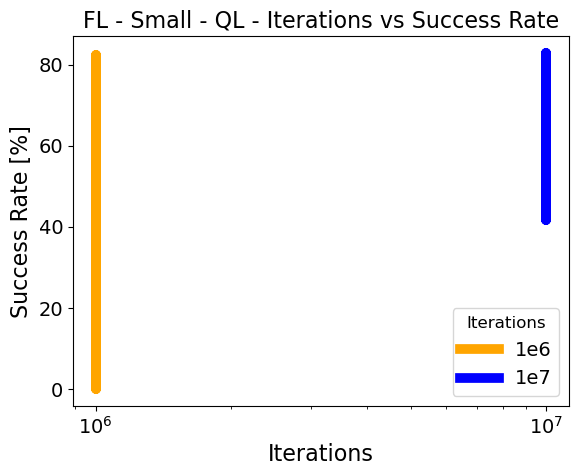

In [139]:
a1 = applied_df_full_1[applied_df_full_1['Iterations']==1000000]
a2 = applied_df_full_1[applied_df_full_1['Iterations']==10000000]

plt.plot(a1['Iterations'],a1['Success_Mean'],linewidth =7,color="orange", label='1e6')
#plt.fill_between(a1['Iterations'], a1['Success_Mean']+a1['Success_StdDev'],a1['Success_Mean']-a1['Success_StdDev'], alpha=0.2, color="blue")


plt.plot(a2['Iterations'],a2['Success_Mean'],linewidth =7,color="blue", label='1e7')
#plt.fill_between(a2['Iterations'], a2['Success_Mean']+a2['Success_StdDev'],a2['Success_Mean']-a2['Success_StdDev'], alpha=0.2, color="orange")

plt.xlabel('Iterations',fontsize = 16)
plt.ylabel('Success Rate [%]',fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xscale('log')
plt.title('FL - Small - QL - Iterations vs Success Rate', fontsize=16)
# plt.legend(title="Hyperparameters", bbox_to_anchor=(1, 1.05),prop={'size': 14})
plt.legend(title="Iterations",title_fontsize=12, loc="best",prop={'size': 14})

In [163]:
import plotly.express as px

fig = px.parallel_coordinates(applied_df_full_1, color="Alpha",
                              dimensions=['Iterations','Alpha', 'Epsilon', 'Gamma',
                                          'Success_Mean'],
                              color_continuous_midpoint=2,
                             )
fig.show()

C:\Users\UGGTech\anaconda3\lib\site-packages\plotly\express\_core.py:279: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



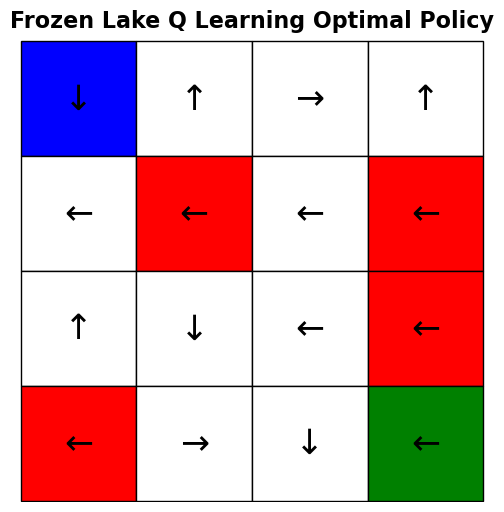

In [38]:
best_policy = np.array(list(q_df.loc[26]["Policy"]))
best_policy = best_policy.reshape(rows, cols)
title='Frozen Lake Q Learning Optimal Policy'
plot_lake(env, best_policy, title='Frozen Lake Q Learning Optimal Policy')

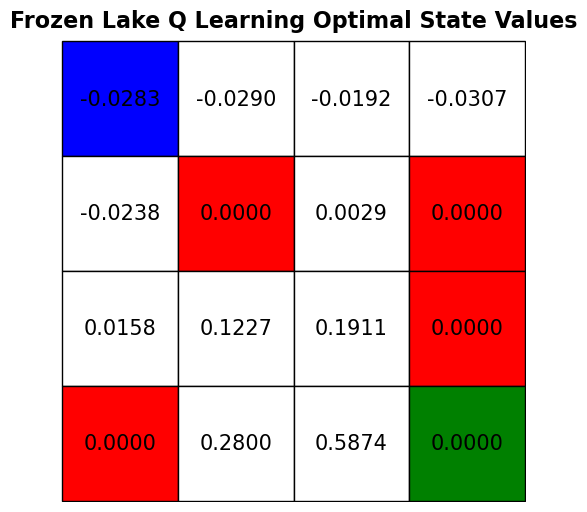

In [40]:
best_val_fn = np.array(list(q_df.loc[26]["Value Function"]))
best_val_fn = best_val_fn.reshape(rows, cols)
plot_lake_values(env, best_val_fn, title='Frozen Lake Q Learning Optimal State Values')